# Overview

This mini-project uses data from [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started). The goal of competition was to identify if a tweet was about a real disaster or not.

# Imports

In [ ]:
!pip install kaleido -q

In [ ]:
from pathlib import Path
from time import perf_counter

import kaleido
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import tqdm

from fastai.text.all import *

# Data

First, we are going to load the data and look at some basic stats.

In [ ]:
# Path Constants
INPUT_DIR = Path("/kaggle/input/nlp-getting-started").resolve()	
TRAIN_FILEPATH = INPUT_DIR / "train.csv"
TEST_FILEPATH = INPUT_DIR / "test.csv"
SAMPLE_SUBMISSION_FILEPATH = INPUT_DIR / "sample_submission.csv"

In [ ]:
train_df = pd.read_csv(TRAIN_FILEPATH)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_FILEPATH)
print(f"train_df.shape: {train_df.shape}")
print(f"sample_submission_df.shape: {sample_submission_df.shape}")
train_df.head()

train_df.shape: (7613, 5)
sample_submission_df.shape: (3263, 2)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


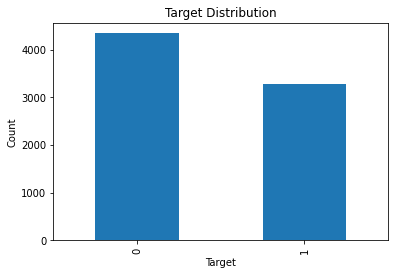

In [ ]:
def show_target_distribution(df):
    fig, ax = plt.subplots()
    df["target"].value_counts().plot(kind="bar", ax=ax)
    ax.set_title("Target Distribution")
    ax.set_xlabel("Target")
    ax.set_ylabel("Count")
    return fig

show_target_distribution(train_df)
plt.show()

The target distribution is mostly balanced and I don't think requires any immediate actions.

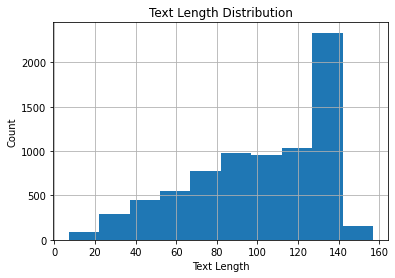

In [ ]:
def plot_text_length_distribution(df):
    fig, ax = plt.subplots()
    df["text"].str.len().hist(ax=ax)
    ax.set_title("Text Length Distribution")
    ax.set_xlabel("Text Length")
    ax.set_ylabel("Count")
    return fig

plot_text_length_distribution(train_df)
plt.show()

Twitter only increased the character limit from 140 to 280 in 2017. From the distribution it seems that the tweets were scraped before the change, but there are a few tweets with more than 140 characters. Let's take a look at one of them.

In [ ]:
def sample_tweets_with_length_over_145(df, count):
    return df[df["text"].str.len() > 145].sample(count)

sampled = sample_tweets_with_length_over_145(train_df, 5)
for i, row in sampled.iterrows():
    text = row.text
    print(f"Tweet of length {len(text)}: {text}")

Tweet of length 146: @IcyMagistrate ÛÓher upper armÛÒ those /friggin/ icicle projectilesÛÒ and leg from various other wounds the girl looks like a miniature moreÛÓ
Tweet of length 148: @Barbi_Twins We need help-horses will die! Please RT &amp; sign petition! Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
Tweet of length 147: ???? throwback Thurs ?? ????  Will You Still Love Me Tomorrow http://t.co/wmoyibWEc1 ??   @LucyMayOfficial  ?? ?? #Whirlwind http://t.co/0rsverLzTm
Tweet of length 148: @helene_yancey GodsLove &amp; #thankU my sister Helene for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami
Tweet of length 149: @UN No more #GujaratRiot &amp; #MumbaiRiot92-93 which devastated 1000&amp;1000 Indianperpetrated by #Modi &amp; #ChawalChorbjp @UN_Women  @UNNewsTeam


Here, we can see that the additional length is due to the character endcodings. So, that seems to be fine

Now, let's check if there are duplicate tweets in the training data.

In [ ]:
def find_duplicate_tweets(df):
    return df[df.duplicated(subset=["text"], keep=False)]

duplicate_tweets = find_duplicate_tweets(train_df)
duplicate_tweets.shape

(179, 5)

There are 179 tweets that have the same text. This needs to be cleaned up, but first we need to check if the duplicates have different targets.

In [ ]:
def find_duplicate_tweets_with_same_targets(df):
    return df[df.duplicated(subset=["text", "target"], keep=False)]

duplicate_tweets_with_same_targets = find_duplicate_tweets_with_same_targets(train_df)
duplicate_tweets_with_diff_targets = duplicate_tweets[
    ~duplicate_tweets.text.isin(duplicate_tweets_with_same_targets.text)
]
duplicate_tweets_with_diff_targets.sort_values(by="text")

,id,keyword,location,text,target
4232,6012,hazardous,NaN,Caution: breathing may be hazardous to your health.,1
4235,6017,hazardous,NaN,Caution: breathing may be hazardous to your health.,0
4306,6113,hellfire,NaN,Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,0
4320,6134,hellfire,Riyadh '),Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,1
1214,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0
1365,1968,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,1
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,1
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,0


There are 8 tweets that are present 2 times with different targets. From their text it is not immediately clear which target is correct. Since there are only a few of them, it is easier to just remove them. After that we can deduplicate other tweets.

In [ ]:
print(train_df.shape)
train_df_wo_duplicated = train_df[~train_df.text.isin(duplicate_tweets_with_diff_targets.text)]
print(train_df_wo_duplicated.shape)
train_df_wo_duplicated = train_df_wo_duplicated[~train_df_wo_duplicated.duplicated(subset=["text"])]
print(train_df_wo_duplicated.shape)

(7613, 5)
(7597, 5)
(7495, 5)


Finally, let's take a look at missing values and number of different unique values, especially for `keyword` and `location` columns.

In [ ]:
train_df_wo_duplicated.isna().sum()

id             0
keyword       56
location    2479
text           0
target         0
dtype: int64

In [ ]:
train_df_wo_duplicated.nunique()

id          7495
keyword      221
location    3323
text        7495
target         2
dtype: int64

`text` and `target` do not have any missing values. They can be used for training without any problems. The other columns, on the other hand, have missing values and a large number of categories. Using `location` is going to be very difficult, so, at first, it's better to drop it. `keyword` is just important words from `text`. They might be useful, but, again, I think it's better to just use `text` at first.

In [ ]:
train_df_new = train_df.loc[:, ["text", "target"]]
train_df_new.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


# Preparing Data and Hyperparameters

Before training the baseline model, we need to define the hyperparameters for it and set up the data loading pipeline. Since I am using fast.ai, it has default preprocessing for text. It might not be the best for this kind of data, but it should be enough for the first few runs

In [ ]:
# Hyperparameters for the baseline model
hyperparameters = {
    "arch": AWD_LSTM,
    "batch_size": 64,
    "seed": 0,
    "valid_pct": 0.2,
    "num_workers": 2,
    "lr": 0.001,
    "weight_decay": 0.01,
    "epochs": 5,
}

In [ ]:
def prepare_data(df, hyperparameters):
    """Create dataloaders for training and validation.
    
    Args:
        df (pd.DataFrame): DataFrame with the training data.
        hyperparameters (dict): Dictionary with the hyperparameters.
    """
    dataloaders = TextDataLoaders.from_df(
        df,
        text_col=0,
        label_col=1,
        valid_pct=hyperparameters["valid_pct"],
        seed=hyperparameters["seed"],
#         text_vocab=None,
        bs=hyperparameters["batch_size"],
        val_bs=hyperparameters["batch_size"]*2,
        num_workers=hyperparameters["num_workers"],
    )
    return dataloaders


dataloaders = prepare_data(train_df_new, hyperparameters)
dataloaders.show_batch()

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
2,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
3,xxbos i xxmaj hate xxmaj to xxmaj talking xxmaj xxunk xxmaj with xxmaj my xxmaj xxunk … i xxmaj mean i xxmaj love xxmaj her xxmaj as xxmaj to xxmaj death xxmaj but xxmaj she xxmaj talk xxmaj so xxmaj damn xxmaj much xxmaj xxunk xxrep 3 h xxrep 3 e xxunk xxrep 3 ! xxrep 6 ?,0
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
5,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
6,xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk p xxup xxunk xxmaj gem xxmaj bu xxup xxunk xxmaj blazing xxup ms xxrep 6 + xxmaj xxunk xxmaj rare xxmaj proof xxmaj like ! - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk,0
7,xxbos xxmaj strong xxmaj thunderstorm 4 xxmaj miles xxmaj north of xxmaj xxunk xxmaj moving xxup se xxmaj at 25 xxup mph . xxmaj large xxmaj hail and xxmaj wind xxmaj gusts xxmaj up to 50 xxup mph xxmaj xxunk … # arwx http : / / t.co / xxunk,1
8,xxbos # nowplaying * xxmaj cliff xxmaj richard - i xxmaj could xxmaj easily xxmaj fall ( in xxmaj love xxmaj with xxmaj you ) ( & & xxmaj xxunk ) * # xxmaj internet # xxmaj xxunk # xxmaj radio xxmaj on http : / / t.co / xxunk,0


Above we can see the default preprocessing for text. It adds utility tokens such as `xxbos` (beginning of sequence), `xxmaj` (capital letter), etc. The texts itself is split inot words and symbols with all characters put into lower case.

Since the competition's metric is F1, it's the metric we need to focus on. I also decided to add accuracy, precision and recall since they can be used to notice if there is any problems with specific class distribution/prediction.

In [ ]:
def get_metrics():
    """Get a list of metrics for cancer dataset."""
    return [accuracy, Precision(), Recall(), F1Score()]

# Training a Baseline Model

With the data loading pipeline done, we can train a baseline model. The learning rate is going to be set using the learning rate finder (it's not always optimial, but usually close enough and doesn't use as much compute as normal tuning).

In [ ]:
def prepare_learner(dataloaders, hyperparameters):
    """Create a learner for training.
    
    Args:
        dataloaders (DataLoaders): DataLoaders for training and validation.
        hyperparameters (dict): Dictionary with the hyperparameters.
    """
    learner = text_classifier_learner(
        dataloaders, hyperparameters["arch"], metrics=get_metrics(),
        config=hyperparameters.get("config", None),
        pretrained=True, drop_mult=hyperparameters.get("drop_mult", 0.5),
        lr=hyperparameters["lr"], wd=hyperparameters["weight_decay"],
        cbs=[ShowGraphCallback()]
    )
    return learner
        
learner = prepare_learner(dataloaders, hyperparameters)

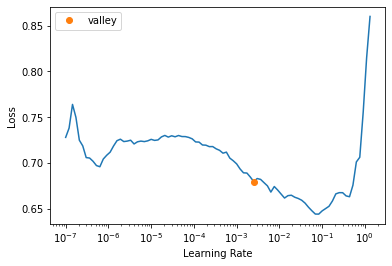

In [ ]:
lr_find = learner.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.601601,0.506320,0.775296,0.801382,0.671491,0.730709,00:14
1,0.556576,0.492457,0.775953,0.811388,0.659913,0.727853,00:14
2,0.543149,0.482185,0.785151,0.822695,0.671491,0.739442,00:15
3,0.532305,0.483056,0.783837,0.822064,0.668596,0.737430,00:14
4,0.519373,0.487556,0.779238,0.858586,0.615051,0.716695,00:15


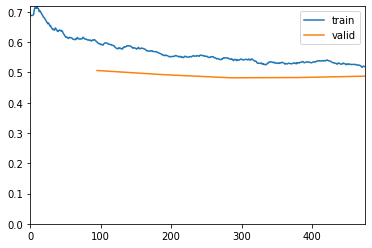

In [ ]:
learner.fit_one_cycle(hyperparameters["epochs"], lr_find.valley)

As we can see, the baseline model is already overfitting. Since our dataset is not that large and we are using a pretrained model, it might be better to do finetuning using gradual unfreezing and differential learning rates (start training only the classifier layer, then other layers with lower learning rate).

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.639957,0.530712,0.743101,0.808642,0.568741,0.667799,00:14


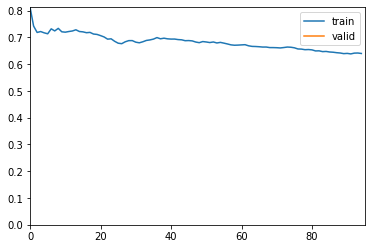

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.602485,0.505393,0.765440,0.840816,0.596237,0.697714,00:15
1,0.574801,0.488453,0.781866,0.844530,0.636758,0.726073,00:15
2,0.554509,0.456462,0.789093,0.842593,0.658466,0.739236,00:14
3,0.527066,0.459817,0.791721,0.859615,0.646889,0.738233,00:15
4,0.520487,0.454087,0.795007,0.848987,0.667149,0.747164,00:15


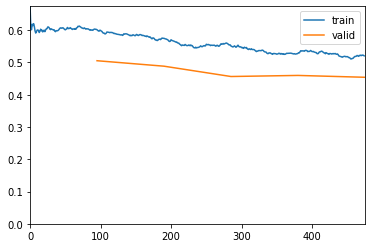

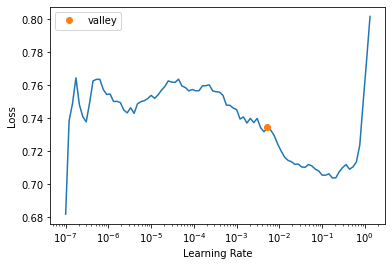

In [ ]:
learner = prepare_learner(dataloaders, hyperparameters)
lr_find = learner.lr_find()
learner.fine_tune(hyperparameters["epochs"], lr_find.valley, freeze_epochs=1)

This performed better, but it is not clear if it is due to an additional epoch of training, but the model is not overfitting as much.

# Hyperparameter Optimization

Since the baseline models didn't show any problems, the next step is to find the best hyperparameters to use during training. We are still going to be using the default text preprocessing. This shouldn't cause any big problems, but it would definitely be better to manually construct a preprocessing pipeline, which is better suited for these data.

For the hyperparameter optimization, I am using `optuna`. It's an optimization library which allows to optimize any arbitrary function with automatic algorithms for finding optimal parameters.

It requires an objective function to optimize and hyperparameters to be sampled. So, we are going to define the objective function.

In [ ]:
# Expanded hyperparameters for hyperparameter search
# Hyperparameters for the baseline model
hyperparameters = {
    "arch":  AWD_LSTM,
    "batch_size": 64,
    "seed": 0,
    "valid_pct": 0.2,
    "num_workers": 2,
    "lr": 0.001,
    "weight_decay": 0.01,
    "epochs": 5,
    "freeze_epochs": 1,
    "output_p": 0.4,
    "hidden_p": 0.3,
    "input_p": 0.4,
    "embed_p": 0.05,
    "weight_p": 0.5,
}

In [ ]:
def train(dataloaders, hyperparameters, cbs=[]):
    """Train a model using the given hyperparameters and callbacks with the learning rate finder.

    Args:
        dataloaders (ImageDataLoaders): DataLoaders for training.
        hyperparameters (dict): Hyperparameters for training.
        cbs (list, optional): Callbacks to use during training.
    """
    learner = prepare_learner(dataloaders, hyperparameters)
    lr_find = learner.lr_find()
    lr = lr_find.valley
    learner.fine_tune(
        hyperparameters["epochs"], lr,
        freeze_epochs=hyperparameters["freeze_epochs"],
        cbs=cbs
    )
    final_score = learner.recorder.values[-1][-1]
    return learner, final_score

For this optimization run, we are going to search through different model hyperparameters (e.g. dropout rates), weight decay, number of epochs and freeze epochs.

In [ ]:
def objective(trial, dataloaders, hyperparameters):
    """Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        dataloaders (ImageDataLoaders): DataLoaders for training.
        hyperparameters (dict): Hyperparameters for training.
    """
    hyperparameters["weight_decay"] = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    hyperparameters["config"] = awd_lstm_clas_config.copy()
    for k in hyperparameters["config"]:
        if k in hyperparameters:
            hyperparameters["config"][k] = hyperparameters[k]
    hyperparameters["config"]["output_p"] = trial.suggest_float("output_p", 0.01, 0.9)
    hyperparameters["config"]["hidden_p"] = trial.suggest_float("hidden_p", 0.01, 0.9)
    hyperparameters["config"]["input_p"] = trial.suggest_float("input_p", 0.01, 0.9)
    hyperparameters["config"]["embed_p"] = trial.suggest_float("embed_p", 0.01, 0.9)
    hyperparameters["config"]["weight_p"] = trial.suggest_float("weight_p", 0.01, 0.9)
    hyperparameters["epochs"] = trial.suggest_int("epochs", 3, 15)
    hyperparameters["freeze_epochs"] = trial.suggest_int("freeze_epochs", 1, 4)
    cbs = [optuna.integration.FastAIV2PruningCallback(trial, monitor="f1_score")]
    
    learner, score = train(dataloaders, hyperparameters, cbs)
    return score

The outputs for hyperoptmizations were pruned in order to make the notebook more readable (the runs produced a lot of logs). Also, `optuna` outputs dynamic plots. They were saved and are now displayed as static images.

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, dataloaders, hyperparameters), n_trials=50)

In [2]:
def show_image(path):
    """Loads image from the path and display it in Jupyter Notebook."""
    from IPython.core.display import Image, display
    display(Image(filename=path, unconfined=True))

0.7800766283524905
{'weight_decay': 0.023683860844847686, 'output_p': 0.3232980557918976, 'hidden_p': 0.5073342208063165,
'input_p': 0.09061707868287391, 'embed_p': 0.10106282846526203, 'weight_p': 0.48881246379274884,
'epochs': 13, 'freeze_epochs': 3}


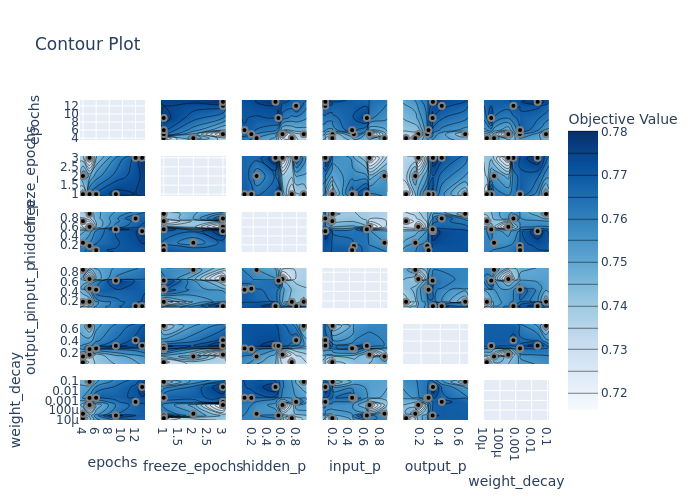

In [3]:
# print(study.best_trial.value, study.best_params)
# fig = optuna.visualization.plot_contour(
#     study, params=["epochs", "freeze_epochs", "weight_decay", "input_p", "hidden_p", "output_p"]
# )
# fig.write_image("hp1_contour.png")
# fig
print((
    "0.7800766283524905\n"
    "{'weight_decay': 0.023683860844847686, 'output_p': 0.3232980557918976, 'hidden_p': 0.5073342208063165,\n"
    "'input_p': 0.09061707868287391, 'embed_p': 0.10106282846526203, 'weight_p': 0.48881246379274884,\n"
    "'epochs': 13, 'freeze_epochs': 3}"
))
show_image("hp1_contour.png")

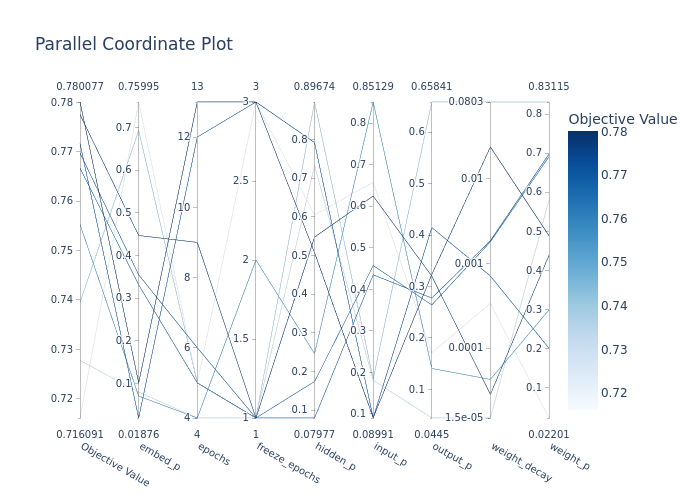

In [4]:
# fig = optuna.visualization.plot_parallel_coordinate(study)
# fig.write_image("hp1_pp_coord.png")
# fig
show_image("hp1_pp_coord.png")

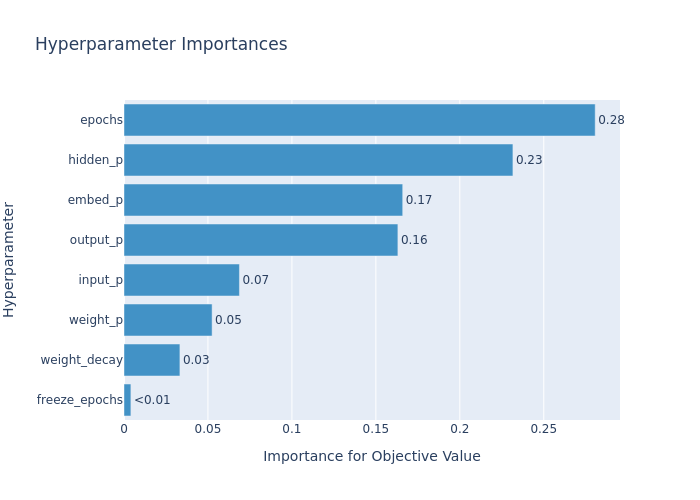

In [5]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.write_image("hp1_importances.png")
# fig
show_image("hp1_importances.png")

After hyperparameter optimization, F1 improved from 0.747 to 0.780. The most important hyperparameter is `epochs` followed by `hidden_p`, `embed_p` and `output_p`. This makes sense, since models are overfitting and regularization is important to prevent that. It seems that `freeze_epochs` is not important at all, but I haven't included not running any freeze epochs, and it's not possible to tell if there is difference between running at least one freeze epochs or training the whole model immediately.

# Training the Final Model

Now, we are going to train the final model using the best hyperparameters and saving the checkpoint with the best F1.

In [ ]:
# Clearing CPU and GPU memory to free up as much as possible for full training.

from time import sleep
import gc
gc.collect()
torch.cuda.empty_cache()
sleep(30)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.606657,0.511609,0.754928,0.766779,0.661360,0.710179,00:15
1,0.575971,0.495566,0.770696,0.821429,0.632417,0.714636,00:14
2,0.562101,0.490104,0.770039,0.797557,0.661360,0.723101,00:14


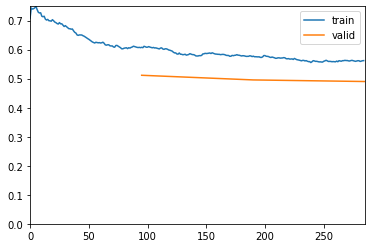

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.542326,0.489316,0.777267,0.838462,0.630970,0.720066,00:16
1,0.527891,0.462297,0.785151,0.825000,0.668596,0.738609,00:15
2,0.509713,0.455135,0.793036,0.819728,0.697540,0.753714,00:15
3,0.475852,0.453017,0.796978,0.809061,0.723589,0.763942,00:15
4,0.455266,0.451393,0.800263,0.809600,0.732272,0.768997,00:15
5,0.431306,0.450197,0.806176,0.820388,0.733719,0.774637,00:14
6,0.404975,0.447130,0.811432,0.834437,0.729378,0.778378,00:15
7,0.374149,0.468846,0.809461,0.817750,0.746744,0.780635,00:15
8,0.348054,0.468556,0.806176,0.797297,0.768452,0.782609,00:15
9,0.340788,0.481183,0.801577,0.821488,0.719247,0.766975,00:15


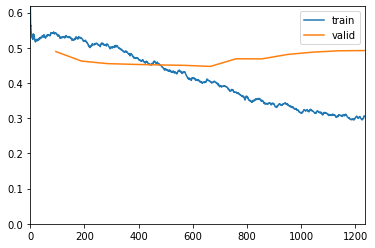

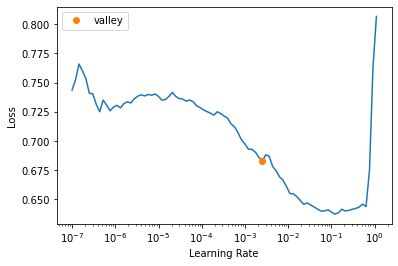

In [ ]:
for k, v in study.best_trial.params.items():
    hyperparameters[k] = v
dataloaders = prepare_data(train_df_new, hyperparameters)
cbs = [SaveModelCallback(monitor='f1_score')]
learner, _ = train(dataloaders, hyperparameters)

Since training is not deterministic, we have a slightly larger F1 score, but the model overfit more to data (validation loss). Otherwise, everything is fine.

# Creating a Submission

In [ ]:
def create_submission(learner):
    """Create a submission file.
    
    Args:
        learner (Learner): Learner for inference.
    """
    test_df = pd.read_csv(TEST_FILEPATH)
    test_dl = learner.dls.test_dl(test_df["text"])
    predictions = learner.get_preds(dl=test_dl)[0].argmax(dim=1)
    submission_df = pd.DataFrame({"id": test_df["id"], "target": predictions})
    submission_df.to_csv("submission.csv", index=False)
    return submission_df

In [ ]:
create_submission(learner).head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# Results

|Model|Val.Loss|F1|
|-|-|-|
|Baseline|0.482|0.739|
|Freeze|0.454|0.747|
|HP Optimization|0.447|0.780|
|Final|0.492|0.781|
|Private|N/A|0.800|

The final model got a private score of 0.800. It seems that we haven't overfit to the training and validation data.

From here there is quite a few possible things to do. We can try out different model architectures, looking at the training samples which the final model misclassified and seeing if the data is corrupted in some way (something wrong with the text, misclassified), improving hyperparameter optimization since F1-score is unstable and median pruning might not work well in this situations. However, I think the two paths with the best potential are improving text preprocessing and adding additional pretraining step.

With text preprocessing it is clear that it can be much more optimized. For example, links can be either removed or replace by a special token, thus, reducing noise and potential for overfitting. Adding an additional pretraining step can also reduce overfitting. Since the pretrained model was not trained on tweets, its distribution is different. By doing unsupervised pretraining on a large corpus of tweets (it is not too difficult to collect) before finetuning on the disaster dataset we might substantially improve model's performance.